In [1]:
%load_ext autoreload
%autoreload 2

# Getting Started 
Make sure your select ***ros_base*** as your kernel. You can do this by clicking on the kernel dropdown menu and selecting *ros_base*.


## Import Python dependencies

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, cm
from IPython.display import HTML
import numpy as np
import csv

import tqdm as tqdm


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from ILQR import RefPath
from ILQR import ILQR



In [3]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

## Generate a reference trajectory

In [4]:
# Define the file paths
config_file = 'task1/task1.yaml'
track_path = 'task1/ref_path.csv'

# Load the reference path
x = []
y = []
left_width = []
right_width = []
with open(track_path, newline='') as f:
    spamreader = csv.reader(f, delimiter=',')
    for i, row in enumerate(spamreader):
        if i>0:
            x.append(float(row[0]))
            y.append(float(row[1]))
            left_width.append(float(row[3]))
            right_width.append(float(row[2]))
            
x = np.array(x)/30.0
y = np.array(y)/30.0
left_width = np.array(left_width)
right_width = np.array(right_width)
center_line = np.array([x,y])


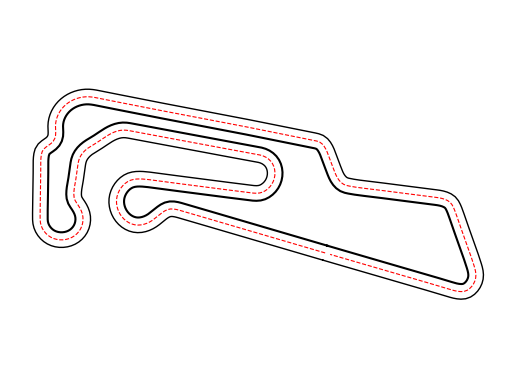

In [5]:
# Create a reference path
ref_path = RefPath(center_line, width_left = 0.6, width_right = 0.6, speed_limt = 5, loop = True)

# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.axis('equal')
_ = plt.axis('off')


## Test your ILQR planner
The planner need to warmup for a few steps for the first time it is run. This process will takes 10-30 seconds depending on your computer.

In [67]:
ilqr = ILQR(config_file)
ilqr.update_ref_path(ref_path)


Line Search Alphas:  [10.    1.    0.1   0.01]
ILQR setting: ILQR config: {'num_dim_x': 5, 'num_dim_u': 2, 'T': 10, 'dt': 0.1, 'platform': 'cpu', 'max_iter': 50, 'tol': 0.05, 'line_search_base': 0.1, 'line_search_a': -1, 'line_search_b': 3, 'line_search_c': 1, 'reg_min': '1e-5', 'reg_max': '1e8', 'reg_scale_down': 5, 'reg_scale_up': 5, 'reg_init': 1.0, 'max_attempt': 5, 'wheelbase': 0.257, 'radius': 0.13, 'width': 0.22, 'length': 0.4, 'delta_max': 0.35, 'delta_min': -0.35, 'v_max': 5.0, 'v_min': 0.0, 'omega_min': -6.0, 'omega_max': 6.0, 'a_max': 5.0, 'a_min': -5.0, 'v_ref': 5.0, 'dim_closest_pt_x': 0, 'dim_closest_pt_y': 1, 'dim_path_slope': 2, 'path_cost_type': 'quadratic', 'path_weight': 2.0, 'path_huber_delta': 2, 'vel_cost_type': 'quadratic', 'vel_weight': 0.2, 'vel_huber_delta': 1, 'dim_vel_limit': 3, 'vel_limit_a': 10.0, 'vel_limit_b': 1.0, 'heading_cost_type': 'quadratic', 'heading_weight': 1, 'heading_huber_delta': 1, 'lat_accel_thres': 6.0, 'lat_accel_a': 5.0, 'lat_accel_b': 2

### Plan for one step

line search failed with reg =  0.0016  at step  3


Text(0.5, 1.0, 'Lateral Acceleration')

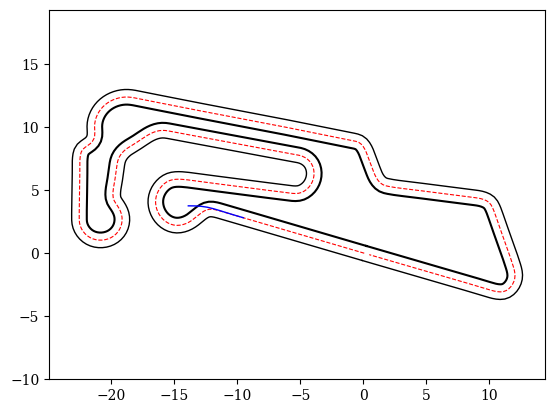

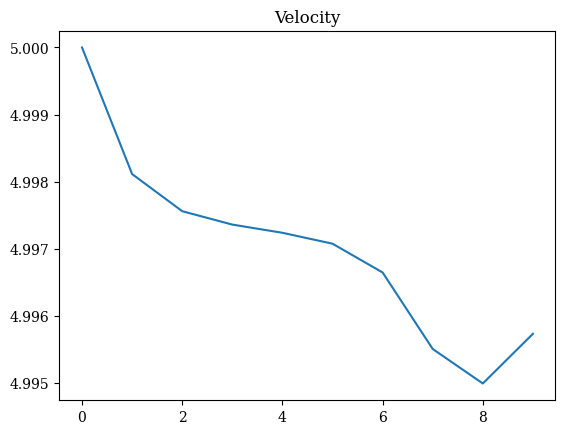

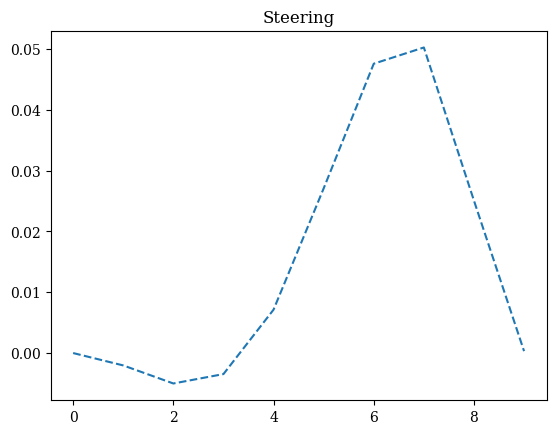

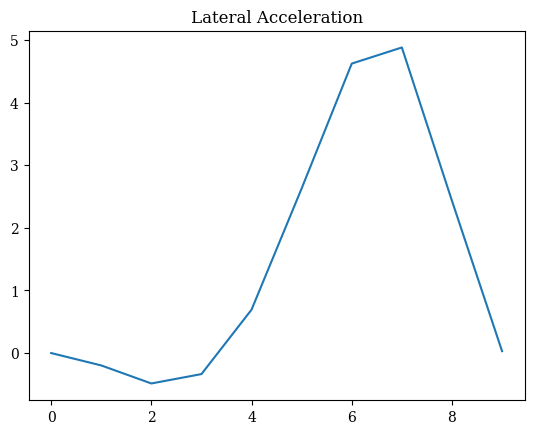

In [69]:
# Create an ILQR solver
x_init = np.array([x[60], y[60], 5, np.arctan2(y[61]-y[60], x[61]-x[60]), 0])
plan = ilqr.plan(x_init)
# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.plot(plan['trajectory'][0, :], plan['trajectory'][1, :], 'b-', linewidth=1)
plt.axis('equal')

plt.figure()
a = plan['trajectory'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['trajectory'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['trajectory'][2, :]**2 / 0.257 * np.tan(plan['trajectory'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')


### Plan for the entire track

In [70]:
itr_receding = 400
init_control = np.zeros((2, ilqr.T))
x_cur = np.array([x[0], y[0], 4, np.arctan2(y[1]-y[0], x[1]-x[0]), 0])
state_history = np.zeros((5,itr_receding + 1))
state_history[:,0] = x_cur
plan_history = np.zeros((5, ilqr.T, itr_receding))
control_history = np.zeros((2,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    plan = ilqr.plan(x_cur, init_control)
    
    trajectory = plan['trajectory']
    controls = plan['controls']
    
    # record the state and control
    state_history[:,i+1]  = trajectory[:,1]
    control_history[:,i] = controls[:,0]
    plan_history[:,:,i] = trajectory
    t_process[i] = plan['t_process']
    
    # prepare for next iteration
    x_cur = trajectory[:,1] 
    init_control[:,:-1] = controls[:,1:]
    
    pbar.set_description(f"ILQR takes : {plan['t_process']:.2f} sec']")

  0%|          | 0/400 [00:00<?, ?it/s]

ILQR takes : 0.04 sec']:   1%|▏         | 5/400 [00:00<00:21, 18.74it/s]

converged after  7  steps.
converged after  1  steps.
converged after  0  steps.
converged after  1  steps.
converged after  4  steps.
converged after  2  steps.


ILQR takes : 0.04 sec']:   3%|▎         | 13/400 [00:00<00:14, 26.63it/s]

line search failed with reg =  0.2  at step  0
converged after  3  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.02 sec']:   4%|▍         | 18/400 [00:00<00:12, 31.18it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  2  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.04 sec']:   6%|▋         | 26/400 [00:00<00:11, 32.11it/s]

converged after  0  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.04  at step  1
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.04  at step  1
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.06 sec']:   8%|▊         | 30/400 [00:01<00:20, 18.23it/s]

line search failed with reg =  0.78125  at step  14
line search failed with reg =  0.008  at step  5
converged after  3  steps.


ILQR takes : 0.02 sec']:   9%|▉         | 36/400 [00:01<00:18, 19.79it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  6.400000000000001e-05  at step  5
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.04 sec']:   9%|▉         | 36/400 [00:01<00:18, 19.79it/s]

line search failed with reg =  1.0  at step  1
line search failed with reg =  0.2  at step  0


ILQR takes : 0.03 sec']:  11%|█▏        | 45/400 [00:02<00:16, 21.71it/s]

converged after  8  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  1  steps.
converged after  1  steps.


ILQR takes : 0.04 sec']:  13%|█▎        | 51/400 [00:02<00:15, 22.79it/s]

converged after  1  steps.
converged after  2  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.01 sec']:  14%|█▎        | 54/400 [00:02<00:16, 21.23it/s]

converged after  4  steps.
converged after  3  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.


ILQR takes : 0.02 sec']:  16%|█▌        | 62/400 [00:02<00:14, 22.68it/s]

line search failed with reg =  0.0016  at step  3
converged after  3  steps.
converged after  0  steps.
converged after  2  steps.
converged after  0  steps.


ILQR takes : 0.05 sec']:  17%|█▋        | 69/400 [00:03<00:12, 25.92it/s]

line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  2  steps.


ILQR takes : 0.06 sec']:  18%|█▊        | 72/400 [00:03<00:14, 22.03it/s]

line search failed with reg =  0.2  at step  0
converged after  4  steps.
line search failed with reg =  0.0016  at step  3


ILQR takes : 0.06 sec']:  19%|█▉        | 75/400 [00:03<00:16, 19.48it/s]

converged after  2  steps.
line search failed with reg =  0.008  at step  2
converged after  2  steps.
line search failed with reg =  0.008  at step  2


ILQR takes : 0.05 sec']:  20%|██        | 82/400 [00:03<00:14, 22.26it/s]

line search failed with reg =  0.008  at step  2
converged after  1  steps.
converged after  1  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.04 sec']:  22%|██▏       | 86/400 [00:03<00:13, 23.23it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  3  steps.
converged after  0  steps.
converged after  1  steps.


ILQR takes : 0.02 sec']:  23%|██▎       | 91/400 [00:04<00:19, 15.93it/s]

line search failed with reg =  1e-05  at step  10
line search failed with reg =  1e-05  at step  8
line search failed with reg =  0.2  at step  0


ILQR takes : 0.04 sec']:  23%|██▎       | 93/400 [00:04<00:21, 14.21it/s]

line search failed with reg =  0.04  at step  1
line search failed with reg =  1e-05  at step  7
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.07 sec']:  24%|██▍       | 97/400 [00:04<00:17, 17.04it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.04 sec']:  26%|██▌       | 102/400 [00:05<00:16, 17.53it/s]

converged after  9  steps.
converged after  0  steps.
converged after  1  steps.
converged after  0  steps.
converged after  1  steps.
converged after  0  steps.


ILQR takes : 0.05 sec']:  27%|██▋       | 108/400 [00:05<00:13, 21.07it/s]

converged after  1  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  1  steps.
converged after  0  steps.


ILQR takes : 0.04 sec']:  28%|██▊       | 111/400 [00:05<00:13, 21.05it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.04  at step  1
line search failed with reg =  0.0016  at step  3
line search failed with reg =  0.2  at step  0


ILQR takes : 0.04 sec']:  29%|██▉       | 117/400 [00:05<00:13, 20.93it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.05 sec']:  30%|███       | 120/400 [00:06<00:24, 11.48it/s]

converged after  21  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.07 sec']:  31%|███▏      | 125/400 [00:06<00:21, 12.81it/s]

converged after  0  steps.
converged after  4  steps.
converged after  3  steps.


ILQR takes : 0.31 sec']:  31%|███▏      | 125/400 [00:06<00:21, 12.81it/s]

converged after  0  steps.


ILQR takes : 0.88 sec']:  32%|███▏      | 127/400 [00:07<00:55,  4.92it/s]

converged after  2  steps.


ILQR takes : 0.35 sec']:  32%|███▏      | 127/400 [00:08<00:55,  4.92it/s]

converged after  0  steps.


ILQR takes : 0.38 sec']:  32%|███▏      | 129/400 [00:08<01:06,  4.07it/s]

converged after  0  steps.


ILQR takes : 1.14 sec']:  32%|███▎      | 130/400 [00:09<01:43,  2.60it/s]

converged after  3  steps.


ILQR takes : 0.57 sec']:  33%|███▎      | 131/400 [00:10<01:52,  2.39it/s]

converged after  1  steps.


ILQR takes : 2.44 sec']:  33%|███▎      | 132/400 [00:12<03:43,  1.20it/s]

converged after  8  steps.


ILQR takes : 1.89 sec']:  33%|███▎      | 133/400 [00:14<04:47,  1.08s/it]

line search failed with reg =  6.400000000000001e-05  at step  5


ILQR takes : 1.15 sec']:  34%|███▎      | 134/400 [00:15<04:50,  1.09s/it]

converged after  3  steps.


ILQR takes : 0.84 sec']:  34%|███▍      | 135/400 [00:16<04:32,  1.03s/it]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.82 sec']:  34%|███▍      | 136/400 [00:17<04:17,  1.03it/s]

converged after  2  steps.


ILQR takes : 0.82 sec']:  34%|███▍      | 137/400 [00:18<04:05,  1.07it/s]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.84 sec']:  34%|███▍      | 138/400 [00:18<03:57,  1.10it/s]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.33 sec']:  35%|███▍      | 139/400 [00:19<03:13,  1.35it/s]

converged after  0  steps.


ILQR takes : 0.85 sec']:  35%|███▌      | 140/400 [00:20<03:21,  1.29it/s]

converged after  2  steps.


ILQR takes : 0.35 sec']:  35%|███▌      | 141/400 [00:20<02:48,  1.54it/s]

converged after  0  steps.


ILQR takes : 1.74 sec']:  36%|███▌      | 142/400 [00:22<04:11,  1.03it/s]

line search failed with reg =  6.400000000000001e-05  at step  5


ILQR takes : 0.34 sec']:  36%|███▌      | 143/400 [00:22<03:22,  1.27it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.35 sec']:  36%|███▌      | 144/400 [00:22<02:47,  1.53it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.35 sec']:  36%|███▋      | 145/400 [00:23<02:24,  1.77it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.35 sec']:  36%|███▋      | 146/400 [00:23<02:07,  2.00it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 3.36 sec']:  37%|███▋      | 147/400 [00:27<05:43,  1.36s/it]

converged after  8  steps.


ILQR takes : 0.37 sec']:  37%|███▋      | 148/400 [00:27<04:27,  1.06s/it]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.37 sec']:  37%|███▋      | 149/400 [00:27<03:34,  1.17it/s]

converged after  0  steps.


ILQR takes : 0.80 sec']:  38%|███▊      | 150/400 [00:28<03:29,  1.19it/s]

converged after  2  steps.


ILQR takes : 0.41 sec']:  38%|███▊      | 151/400 [00:28<02:57,  1.41it/s]

converged after  0  steps.


ILQR takes : 0.35 sec']:  38%|███▊      | 152/400 [00:29<02:29,  1.66it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.64 sec']:  38%|███▊      | 153/400 [00:29<02:31,  1.63it/s]

line search failed with reg =  0.04  at step  1


ILQR takes : 0.82 sec']:  38%|███▊      | 154/400 [00:30<02:46,  1.48it/s]

converged after  2  steps.


ILQR takes : 0.34 sec']:  39%|███▉      | 155/400 [00:31<02:21,  1.74it/s]

converged after  0  steps.


ILQR takes : 0.35 sec']:  39%|███▉      | 156/400 [00:31<02:04,  1.96it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.38 sec']:  39%|███▉      | 157/400 [00:31<01:54,  2.11it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.35 sec']:  40%|███▉      | 158/400 [00:32<01:45,  2.29it/s]

converged after  0  steps.


ILQR takes : 0.34 sec']:  40%|███▉      | 159/400 [00:32<01:38,  2.45it/s]

converged after  0  steps.


ILQR takes : 0.35 sec']:  40%|████      | 160/400 [00:32<01:33,  2.55it/s]

converged after  0  steps.


ILQR takes : 0.33 sec']:  40%|████      | 161/400 [00:33<01:29,  2.67it/s]

converged after  0  steps.


ILQR takes : 4.31 sec']:  40%|████      | 162/400 [00:37<06:10,  1.55s/it]

converged after  14  steps.


ILQR takes : 0.39 sec']:  41%|████      | 163/400 [00:37<04:45,  1.21s/it]

converged after  0  steps.


ILQR takes : 0.75 sec']:  41%|████      | 164/400 [00:38<04:12,  1.07s/it]

converged after  2  steps.


ILQR takes : 0.32 sec']:  41%|████▏     | 165/400 [00:39<03:18,  1.18it/s]

converged after  0  steps.


ILQR takes : 0.42 sec']:  42%|████▏     | 166/400 [00:39<02:48,  1.39it/s]

converged after  0  steps.


ILQR takes : 0.98 sec']:  42%|████▏     | 167/400 [00:40<03:06,  1.25it/s]

converged after  3  steps.


ILQR takes : 0.31 sec']:  42%|████▏     | 168/400 [00:40<02:31,  1.53it/s]

converged after  0  steps.


ILQR takes : 0.81 sec']:  42%|████▏     | 169/400 [00:41<02:41,  1.43it/s]

converged after  2  steps.


ILQR takes : 0.28 sec']:  42%|████▎     | 170/400 [00:41<02:11,  1.74it/s]

converged after  0  steps.


ILQR takes : 0.55 sec']:  43%|████▎     | 171/400 [00:42<02:09,  1.76it/s]

converged after  1  steps.


ILQR takes : 0.83 sec']:  43%|████▎     | 172/400 [00:43<02:27,  1.55it/s]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.80 sec']:  43%|████▎     | 173/400 [00:44<02:37,  1.44it/s]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.82 sec']:  44%|████▎     | 174/400 [00:44<02:45,  1.37it/s]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.58 sec']:  44%|████▍     | 175/400 [00:45<02:34,  1.46it/s]

converged after  1  steps.


ILQR takes : 0.30 sec']:  44%|████▍     | 176/400 [00:45<02:08,  1.75it/s]

converged after  0  steps.


ILQR takes : 0.32 sec']:  44%|████▍     | 177/400 [00:46<01:51,  2.01it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.32 sec']:  44%|████▍     | 178/400 [00:46<01:38,  2.25it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.32 sec']:  45%|████▍     | 179/400 [00:46<01:30,  2.45it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 1.29 sec']:  45%|████▌     | 180/400 [00:48<02:28,  1.48it/s]

converged after  4  steps.


ILQR takes : 1.50 sec']:  45%|████▌     | 181/400 [00:49<03:22,  1.08it/s]

converged after  5  steps.


ILQR takes : 0.31 sec']:  46%|████▌     | 182/400 [00:49<02:41,  1.35it/s]

converged after  0  steps.


ILQR takes : 0.38 sec']:  46%|████▌     | 183/400 [00:50<02:16,  1.58it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.36 sec']:  46%|████▌     | 184/400 [00:50<01:59,  1.81it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.30 sec']:  46%|████▋     | 185/400 [00:50<01:42,  2.09it/s]

converged after  0  steps.


ILQR takes : 0.31 sec']:  46%|████▋     | 186/400 [00:51<01:31,  2.33it/s]

converged after  0  steps.


ILQR takes : 0.97 sec']:  47%|████▋     | 187/400 [00:52<02:05,  1.69it/s]

converged after  3  steps.


ILQR takes : 0.31 sec']:  47%|████▋     | 188/400 [00:52<01:47,  1.97it/s]

converged after  0  steps.


ILQR takes : 0.28 sec']:  47%|████▋     | 189/400 [00:52<01:32,  2.27it/s]

converged after  0  steps.


ILQR takes : 0.29 sec']:  48%|████▊     | 190/400 [00:53<01:23,  2.53it/s]

converged after  0  steps.


ILQR takes : 0.29 sec']:  48%|████▊     | 191/400 [00:53<01:16,  2.73it/s]

converged after  0  steps.


ILQR takes : 0.36 sec']:  48%|████▊     | 192/400 [00:53<01:15,  2.74it/s]

converged after  0  steps.


ILQR takes : 0.32 sec']:  48%|████▊     | 193/400 [00:54<01:12,  2.85it/s]

converged after  0  steps.


ILQR takes : 0.29 sec']:  48%|████▊     | 194/400 [00:54<01:08,  3.01it/s]

converged after  0  steps.


ILQR takes : 0.36 sec']:  49%|████▉     | 195/400 [00:54<01:09,  2.94it/s]

converged after  0  steps.


ILQR takes : 0.59 sec']:  49%|████▉     | 196/400 [00:55<01:25,  2.40it/s]

converged after  1  steps.


ILQR takes : 0.40 sec']:  49%|████▉     | 197/400 [00:55<01:24,  2.42it/s]

converged after  0  steps.


ILQR takes : 0.33 sec']:  50%|████▉     | 198/400 [00:56<01:18,  2.57it/s]

converged after  0  steps.


ILQR takes : 0.31 sec']:  50%|████▉     | 199/400 [00:56<01:13,  2.74it/s]

converged after  0  steps.


ILQR takes : 0.28 sec']:  50%|█████     | 200/400 [00:56<01:08,  2.94it/s]

converged after  0  steps.


ILQR takes : 0.28 sec']:  50%|█████     | 201/400 [00:56<01:04,  3.11it/s]

converged after  0  steps.


ILQR takes : 0.32 sec']:  50%|█████     | 202/400 [00:57<01:03,  3.10it/s]

converged after  0  steps.


ILQR takes : 0.32 sec']:  51%|█████     | 203/400 [00:57<01:03,  3.09it/s]

converged after  0  steps.


ILQR takes : 0.50 sec']:  51%|█████     | 204/400 [00:58<01:14,  2.64it/s]

converged after  1  steps.


ILQR takes : 0.28 sec']:  51%|█████▏    | 205/400 [00:58<01:08,  2.86it/s]

converged after  0  steps.


ILQR takes : 0.28 sec']:  52%|█████▏    | 206/400 [00:58<01:04,  3.02it/s]

converged after  0  steps.


ILQR takes : 0.40 sec']:  52%|█████▏    | 207/400 [00:58<01:07,  2.84it/s]

converged after  0  steps.


ILQR takes : 0.34 sec']:  52%|█████▏    | 208/400 [00:59<01:06,  2.88it/s]

converged after  0  steps.


ILQR takes : 0.33 sec']:  52%|█████▏    | 209/400 [00:59<01:05,  2.92it/s]

converged after  0  steps.


ILQR takes : 0.36 sec']:  52%|█████▎    | 210/400 [01:00<01:06,  2.88it/s]

converged after  0  steps.


ILQR takes : 0.35 sec']:  53%|█████▎    | 211/400 [01:00<01:05,  2.88it/s]

converged after  0  steps.


ILQR takes : 0.29 sec']:  53%|█████▎    | 212/400 [01:00<01:02,  3.02it/s]

converged after  0  steps.


ILQR takes : 0.95 sec']:  53%|█████▎    | 213/400 [01:01<01:36,  1.93it/s]

converged after  3  steps.


ILQR takes : 0.64 sec']:  54%|█████▎    | 214/400 [01:02<01:42,  1.81it/s]

converged after  1  steps.


ILQR takes : 1.20 sec']:  54%|█████▍    | 215/400 [01:03<02:18,  1.33it/s]

converged after  4  steps.


ILQR takes : 1.02 sec']:  54%|█████▍    | 216/400 [01:04<02:33,  1.20it/s]

converged after  3  steps.


ILQR takes : 0.90 sec']:  54%|█████▍    | 217/400 [01:05<02:36,  1.17it/s]

converged after  3  steps.


ILQR takes : 0.30 sec']:  55%|█████▍    | 218/400 [01:05<02:05,  1.45it/s]

converged after  0  steps.


ILQR takes : 0.27 sec']:  55%|█████▍    | 219/400 [01:05<01:42,  1.77it/s]

converged after  0  steps.


ILQR takes : 0.27 sec']:  55%|█████▌    | 220/400 [01:06<01:25,  2.10it/s]

converged after  0  steps.


ILQR takes : 3.43 sec']:  55%|█████▌    | 221/400 [01:09<04:03,  1.36s/it]

converged after  14  steps.


ILQR takes : 0.73 sec']:  56%|█████▌    | 222/400 [01:10<03:28,  1.17s/it]

converged after  2  steps.


ILQR takes : 3.21 sec']:  56%|█████▌    | 223/400 [01:13<05:15,  1.79s/it]

converged after  7  steps.


ILQR takes : 0.69 sec']:  56%|█████▌    | 224/400 [01:14<04:16,  1.46s/it]

converged after  2  steps.


ILQR takes : 0.29 sec']:  56%|█████▋    | 225/400 [01:14<03:13,  1.11s/it]

converged after  0  steps.


ILQR takes : 0.77 sec']:  56%|█████▋    | 226/400 [01:15<02:55,  1.01s/it]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.30 sec']:  57%|█████▋    | 227/400 [01:15<02:17,  1.26it/s]

converged after  0  steps.


ILQR takes : 0.27 sec']:  57%|█████▋    | 228/400 [01:15<01:49,  1.57it/s]

converged after  0  steps.


ILQR takes : 0.27 sec']:  57%|█████▋    | 229/400 [01:16<01:30,  1.89it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.71 sec']:  57%|█████▊    | 230/400 [01:16<01:39,  1.71it/s]

converged after  2  steps.


ILQR takes : 1.39 sec']:  58%|█████▊    | 231/400 [01:18<02:19,  1.21it/s]

converged after  5  steps.


ILQR takes : 0.29 sec']:  58%|█████▊    | 232/400 [01:18<01:51,  1.51it/s]

converged after  0  steps.


ILQR takes : 0.29 sec']:  58%|█████▊    | 233/400 [01:18<01:32,  1.80it/s]

converged after  0  steps.


ILQR takes : 0.29 sec']:  58%|█████▊    | 234/400 [01:19<01:18,  2.10it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.30 sec']:  59%|█████▉    | 235/400 [01:19<01:10,  2.36it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.27 sec']:  59%|█████▉    | 236/400 [01:19<01:02,  2.64it/s]

converged after  0  steps.


ILQR takes : 0.69 sec']:  59%|█████▉    | 237/400 [01:20<01:17,  2.11it/s]

converged after  2  steps.


ILQR takes : 0.29 sec']:  60%|█████▉    | 238/400 [01:20<01:07,  2.38it/s]

converged after  0  steps.


ILQR takes : 0.50 sec']:  60%|█████▉    | 239/400 [01:21<01:11,  2.25it/s]

converged after  1  steps.


ILQR takes : 1.59 sec']:  60%|██████    | 240/400 [01:22<02:06,  1.27it/s]

converged after  5  steps.


ILQR takes : 0.63 sec']:  60%|██████    | 241/400 [01:23<01:58,  1.34it/s]

converged after  1  steps.


ILQR takes : 0.77 sec']:  60%|██████    | 242/400 [01:24<01:58,  1.33it/s]

converged after  2  steps.


ILQR takes : 0.73 sec']:  61%|██████    | 243/400 [01:25<01:57,  1.34it/s]

line search failed with reg =  0.008  at step  2


ILQR takes : 0.30 sec']:  61%|██████    | 244/400 [01:25<01:35,  1.63it/s]

converged after  0  steps.


ILQR takes : 0.25 sec']:  61%|██████▏   | 245/400 [01:25<01:18,  1.97it/s]

converged after  0  steps.


ILQR takes : 0.25 sec']:  62%|██████▏   | 246/400 [01:25<01:06,  2.32it/s]

converged after  0  steps.


ILQR takes : 0.33 sec']:  62%|██████▏   | 247/400 [01:26<01:01,  2.50it/s]

converged after  0  steps.


ILQR takes : 0.91 sec']:  62%|██████▏   | 248/400 [01:27<01:24,  1.81it/s]

converged after  3  steps.


ILQR takes : 1.11 sec']:  62%|██████▏   | 249/400 [01:28<01:48,  1.39it/s]

converged after  4  steps.


ILQR takes : 0.25 sec']:  62%|██████▎   | 250/400 [01:28<01:27,  1.72it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.29 sec']:  63%|██████▎   | 251/400 [01:28<01:13,  2.02it/s]

line search failed with reg =  0.2  at step  0


ILQR takes : 0.63 sec']:  63%|██████▎   | 252/400 [01:29<01:19,  1.87it/s]

converged after  2  steps.


ILQR takes : 0.27 sec']:  63%|██████▎   | 253/400 [01:29<01:07,  2.19it/s]

converged after  0  steps.


ILQR takes : 0.64 sec']:  64%|██████▎   | 254/400 [01:30<01:14,  1.95it/s]

converged after  1  steps.


ILQR takes : 1.31 sec']:  64%|██████▍   | 255/400 [01:31<01:49,  1.33it/s]

converged after  6  steps.


ILQR takes : 1.17 sec']:  64%|██████▍   | 256/400 [01:32<02:06,  1.14it/s]

line search failed with reg =  6.400000000000001e-05  at step  5


ILQR takes : 0.78 sec']:  64%|██████▍   | 257/400 [01:33<02:01,  1.18it/s]

line search failed with reg =  0.0016  at step  3


ILQR takes : 0.55 sec']:  64%|██████▍   | 258/400 [01:34<01:47,  1.32it/s]

converged after  2  steps.


ILQR takes : 0.82 sec']:  65%|██████▍   | 259/400 [01:34<01:49,  1.28it/s]

line search failed with reg =  0.0016  at step  3


ILQR takes : 0.42 sec']:  65%|██████▌   | 260/400 [01:35<01:34,  1.49it/s]

converged after  1  steps.


ILQR takes : 0.41 sec']:  65%|██████▌   | 261/400 [01:35<01:22,  1.68it/s]

line search failed with reg =  0.04  at step  1


ILQR takes : 0.21 sec']:  66%|██████▌   | 262/400 [01:35<01:06,  2.09it/s]

converged after  0  steps.


ILQR takes : 0.21 sec']:  66%|██████▌   | 263/400 [01:36<00:54,  2.51it/s]

converged after  0  steps.


ILQR takes : 0.22 sec']:  66%|██████▌   | 264/400 [01:36<00:47,  2.88it/s]

converged after  0  steps.


ILQR takes : 0.39 sec']:  66%|██████▋   | 265/400 [01:36<00:48,  2.77it/s]

converged after  1  steps.


ILQR takes : 0.01 sec']:  68%|██████▊   | 270/400 [01:37<00:24,  5.21it/s]

converged after  3  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  4  steps.
converged after  0  steps.


ILQR takes : 0.02 sec']:  70%|██████▉   | 279/400 [01:37<00:08, 13.73it/s]

converged after  2  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  1  steps.
converged after  0  steps.
converged after  1  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.01 sec']:  73%|███████▎  | 291/400 [01:38<00:04, 26.90it/s]

line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.02 sec']:  76%|███████▌  | 302/400 [01:38<00:02, 35.16it/s]

line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.04 sec']:  78%|███████▊  | 312/400 [01:38<00:02, 37.87it/s]

converged after  1  steps.
line search failed with reg =  0.2  at step  0
converged after  2  steps.
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.02 sec']:  79%|███████▉  | 317/400 [01:38<00:02, 33.76it/s]

line search failed with reg =  6.400000000000001e-05  at step  5
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.04  at step  1
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.008  at step  2
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.07 sec']:  80%|████████  | 321/400 [01:39<00:02, 32.24it/s]

line search failed with reg =  1.0  at step  2
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.00032  at step  4
line search failed with reg =  25.0  at step  4


ILQR takes : 0.05 sec']:  81%|████████▏ | 325/400 [01:39<00:02, 27.40it/s]

line search failed with reg =  25.0  at step  0
line search failed with reg =  25.0  at step  0
line search failed with reg =  25.0  at step  0


ILQR takes : 0.02 sec']:  82%|████████▏ | 329/400 [01:39<00:04, 17.54it/s]

line search failed with reg =  25.0  at step  8
converged after  11  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.05 sec']:  84%|████████▍ | 337/400 [01:39<00:02, 22.56it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  1  steps.
converged after  0  steps.
line search failed with reg =  0.04  at step  1
converged after  2  steps.


ILQR takes : 0.19 sec']:  84%|████████▍ | 337/400 [01:40<00:02, 22.56it/s]

converged after  4  steps.
converged after  16  steps.


ILQR takes : 0.04 sec']:  86%|████████▌ | 344/400 [01:40<00:02, 20.60it/s]

converged after  1  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  1  steps.
converged after  2  steps.


ILQR takes : 0.05 sec']:  88%|████████▊ | 352/400 [01:40<00:01, 24.43it/s]

converged after  5  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  3  steps.


ILQR takes : 0.01 sec']:  89%|████████▉ | 355/400 [01:40<00:01, 23.52it/s]

converged after  4  steps.
line search failed with reg =  0.2  at step  0
converged after  2  steps.
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.04 sec']:  90%|█████████ | 360/400 [01:40<00:01, 27.41it/s]

line search failed with reg =  0.2  at step  0
converged after  1  steps.
converged after  1  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.05 sec']:  92%|█████████▏| 367/400 [01:41<00:01, 21.58it/s]

converged after  6  steps.
converged after  2  steps.
line search failed with reg =  0.0016  at step  3
line search failed with reg =  0.008  at step  2


ILQR takes : 0.06 sec']:  92%|█████████▎| 370/400 [01:41<00:01, 20.72it/s]

line search failed with reg =  0.008  at step  2
line search failed with reg =  0.008  at step  2
line search failed with reg =  0.04  at step  1
converged after  1  steps.
line search failed with reg =  0.008  at step  2


ILQR takes : 0.04 sec']:  94%|█████████▍| 376/400 [01:41<00:01, 23.73it/s]

converged after  0  steps.
converged after  1  steps.
converged after  0  steps.
converged after  0  steps.
converged after  2  steps.


ILQR takes : 0.03 sec']:  95%|█████████▍| 379/400 [01:41<00:01, 17.38it/s]

converged after  5  steps.
converged after  10  steps.
line search failed with reg =  0.2  at step  0


ILQR takes : 0.02 sec']:  96%|█████████▌| 382/400 [01:42<00:01, 14.84it/s]

line search failed with reg =  1e-05  at step  7
line search failed with reg =  1.2800000000000003e-05  at step  6
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.01 sec']:  96%|█████████▋| 385/400 [01:42<00:01, 14.28it/s]

line search failed with reg =  1e-05  at step  7
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0
line search failed with reg =  0.2  at step  0


ILQR takes : 0.14 sec']:  98%|█████████▊| 392/400 [01:42<00:00, 14.25it/s]

converged after  13  steps.
converged after  1  steps.
converged after  5  steps.


ILQR takes : 0.04 sec']: 100%|█████████▉| 398/400 [01:43<00:00, 19.25it/s]

converged after  3  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.09 sec']: 100%|██████████| 400/400 [01:43<00:00,  3.88it/s]

converged after  2  steps.


### Visualize the results

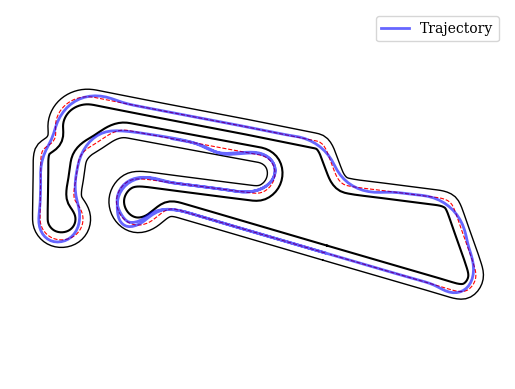

In [72]:
plt.figure()
plt.plot(state_history[0,:], state_history[1,:], 'b-', linewidth= 2, alpha =0.6, label = 'Trajectory')
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.legend(prop={'size': 10})
plt.axis('equal')
plt.axis('off')
plt.show()

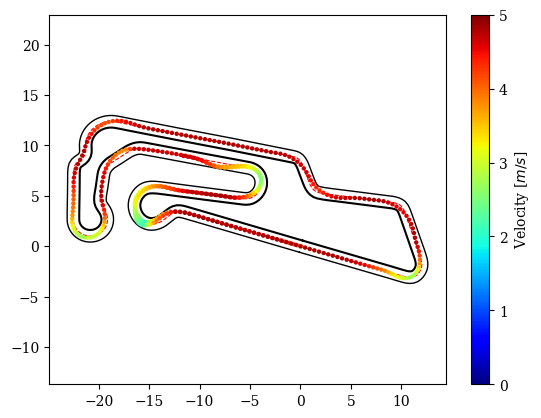

In [73]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')

sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=state_history[2,:-1], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Velocity [$m/s$]", size=10)
plt.axis('equal')
plt.show()

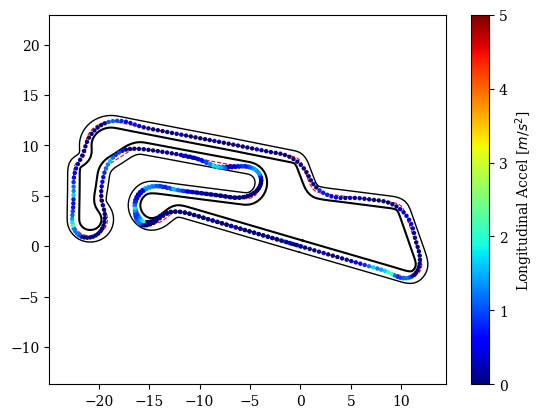

In [74]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=control_history[0,:], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Longitudinal Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

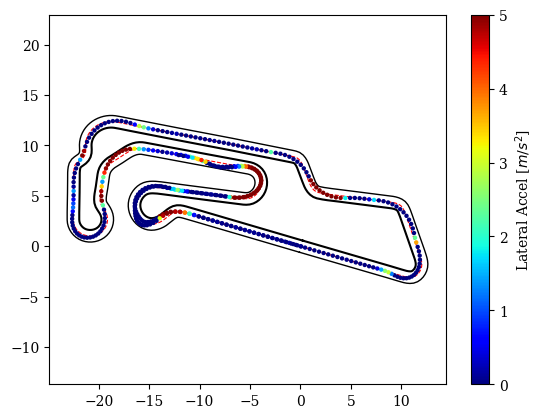

In [75]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
alat = state_history[2,:]**2*np.tan(state_history[-1,:])/0.257
sc = plt.scatter(state_history[0, ], state_history[1,], s = 10, 
                c=alat, cmap=cm.jet, 
                vmin = 0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Lateral Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

In [76]:
sim = plt.figure()
ref_path.plot_track()
plan_plot = plt.plot([], [], linewidth= 2)[0]
traj_plot = plt.scatter([], [], s = 10, c=[], cmap=cm.jet, vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(traj_plot)
cbar.set_label(r"velocity [$m/s$]", size=20)
plt.axis('equal')
plt.close()

def drawframe(n):
    traj_plot.set_offsets(state_history[:2,:n+1].T)
    traj_plot.set_array(state_history[2,:n+1])
    plan_plot.set_data(plan_history[0,:, n], plan_history[1,:, n])
    
    return (traj_plot,plan_plot)


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(sim, drawframe, frames=itr_receding, interval=ilqr.dt*1000, blit=True)
HTML(anim.to_html5_video())